<a href="https://colab.research.google.com/github/anuvrat-umich/siads_milestone1/blob/alex/data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import ipywidgets as widgets
from IPython.display import display
import re
import folium
import seaborn as sn
import numpy as np
import matplotlib.ticker as ticker

In [ ]:
# Clean income data
def clean_income_data(data):
    income_data = pd.read_csv(data, header=None)

    new_header = income_data.iloc[1] # store second row
    income_data = income_data[2:] # remove first 2 rows
    income_data.columns = new_header # make header previous second row

    income_data['Geographic Area Name'] = income_data['Geographic Area Name'].str.extract('(\d{5})') # Get just the zip code

    # Filter specific columns
    income_data = income_data[['Geographic Area Name',
                               'Estimate!!Households!!Mean income (dollars)']]

    income_data.columns = [['Zip Code', 'Households Mean Income']]

    return income_data


In [ ]:
# Clean health outcomes data
def clean_health_data(data):
    health_data = pd.read_csv(data)
    health_data['LocationName'] = health_data['LocationName'].astype(str).str.zfill(5)



    return health_data

# Load Data

In [ ]:
# 2022 Income Data
income_data_2022 = clean_income_data('/content/drive/MyDrive/Milestone1/income_data_2022.csv')

<ipython-input-262-dc5140cc50a0>:3: DtypeWarning: Columns (2,3,34,35,66,67,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  income_data = pd.read_csv(data, header=None)


In [ ]:
# Health Outcomes
health_outcomes = clean_health_data('/content/drive/MyDrive/Milestone1/health_outcomes.csv')

<ipython-input-165-ac45ba4be145>:3: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  health_data = pd.read_csv(data)


In [ ]:
# Zip Codes
zip_codes = pd.read_excel('/content/drive/MyDrive/Milestone1/zip_codes.xlsx')

# View Data

In [ ]:
income_data_2022.head(1)

,Zip Code,Households Mean Income
2,00601,23091


In [ ]:
health_outcomes.head(1)

,Year,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Footnote_Symbol,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,Geolocation,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text
0,2021,01001,BRFSS,Prevention,Current lack of health insurance among adults ...,%,Crude prevalence,4.1,NaN,NaN,3.4,5.0,16769,POINT (-72.62581515 42.06255509),1001,PREVENT,ACCESS2,CrdPrv,Health Insurance


In [ ]:
health_outcomes.head(1)

,Year,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Footnote_Symbol,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,Geolocation,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text
0,2021,01001,BRFSS,Prevention,Current lack of health insurance among adults ...,%,Crude prevalence,4.1,NaN,NaN,3.4,5.0,16769,POINT (-72.62581515 42.06255509),1001,PREVENT,ACCESS2,CrdPrv,Health Insurance


# Merge Zip Codes and State Names

In [ ]:
states = zip_codes['Official State Name'].unique()
states = states.tolist()
remove = ['Guam', 'Puerto Rico', 'District of Columbia', 'Northern Mariana Islands', 'Virgin Islands', 'American Samoa']
states = sorted(list(filter(lambda item: item not in remove, states)))

In [ ]:
state_zips = zip_codes[['Zip Code', 'Official State Name']]
state_zips['Zip Code'] = state_zips['Zip Code'].astype(str)
state_zips = state_zips.sort_values(by=['Zip Code'])

<ipython-input-322-d9fff1f012d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_zips['Zip Code'] = state_zips['Zip Code'].astype(str)


In [ ]:
income_data_2022.columns = income_data_2022.columns.get_level_values(0)
income_data_2022['Zip Code'] = income_data_2022['Zip Code'].astype(str).str.zfill(5)
income_data_2022 = income_data_2022.sort_values(by=['Zip Code'])

In [ ]:
data_merged = state_zips.merge(income_data_2022, how='inner', on='Zip Code')


for column in data_merged.columns:
    # Skip the 'Official State Name' column
    if column != 'Official State Name':
        # Convert the column to numeric first to handle non-numeric values
        data_merged[column] = pd.to_numeric(data_merged[column], errors='coerce')
        # Drop rows with NaN values that resulted from coercion (if desired)
        data_merged.dropna(subset=[column], inplace=True)
        # Convert the column to integers, assuming NaN values are handled or non-existent
        data_merged[column] = data_merged[column].astype(int)

# Drop rows with NaN values (rows that contained non-numeric data)
data_merged.dropna(inplace=True)
data_merged = data_merged.sort_values(by=['Official State Name'])

# Histogram of Household Incomes by State

In [ ]:
# Define bin edges
bin_edges = np.arange(0, 1000000 + 25000, 25000)  # +30000 to include the upper edge

def plot_histogram_for_state_with_bins(state_name):
    # Filter the DataFrame for the selected state
    filtered_data = data_merged[data_merged['Official State Name'] == state_name]

    # Plotting the histogram with predefined bins
    plt.figure(figsize=(25, 10))
    plt.hist(filtered_data['Households Mean Income'], bins=bin_edges, color='skyblue', edgecolor='black')
    plt.title(f'Households Mean Income Distribution in {state_name}')
    plt.xlabel('Households Mean Income')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

    # Rotate x-axis ticks for better readability
    plt.xticks(bin_edges, rotation=45)

    # Adding a x-axis limit to make the plot neater
    plt.xlim(0, 1000000)

    # Set x-axis tick formatting to plain style (no scientific notation)
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


    plt.show()




Dropdown(description='State:', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', …

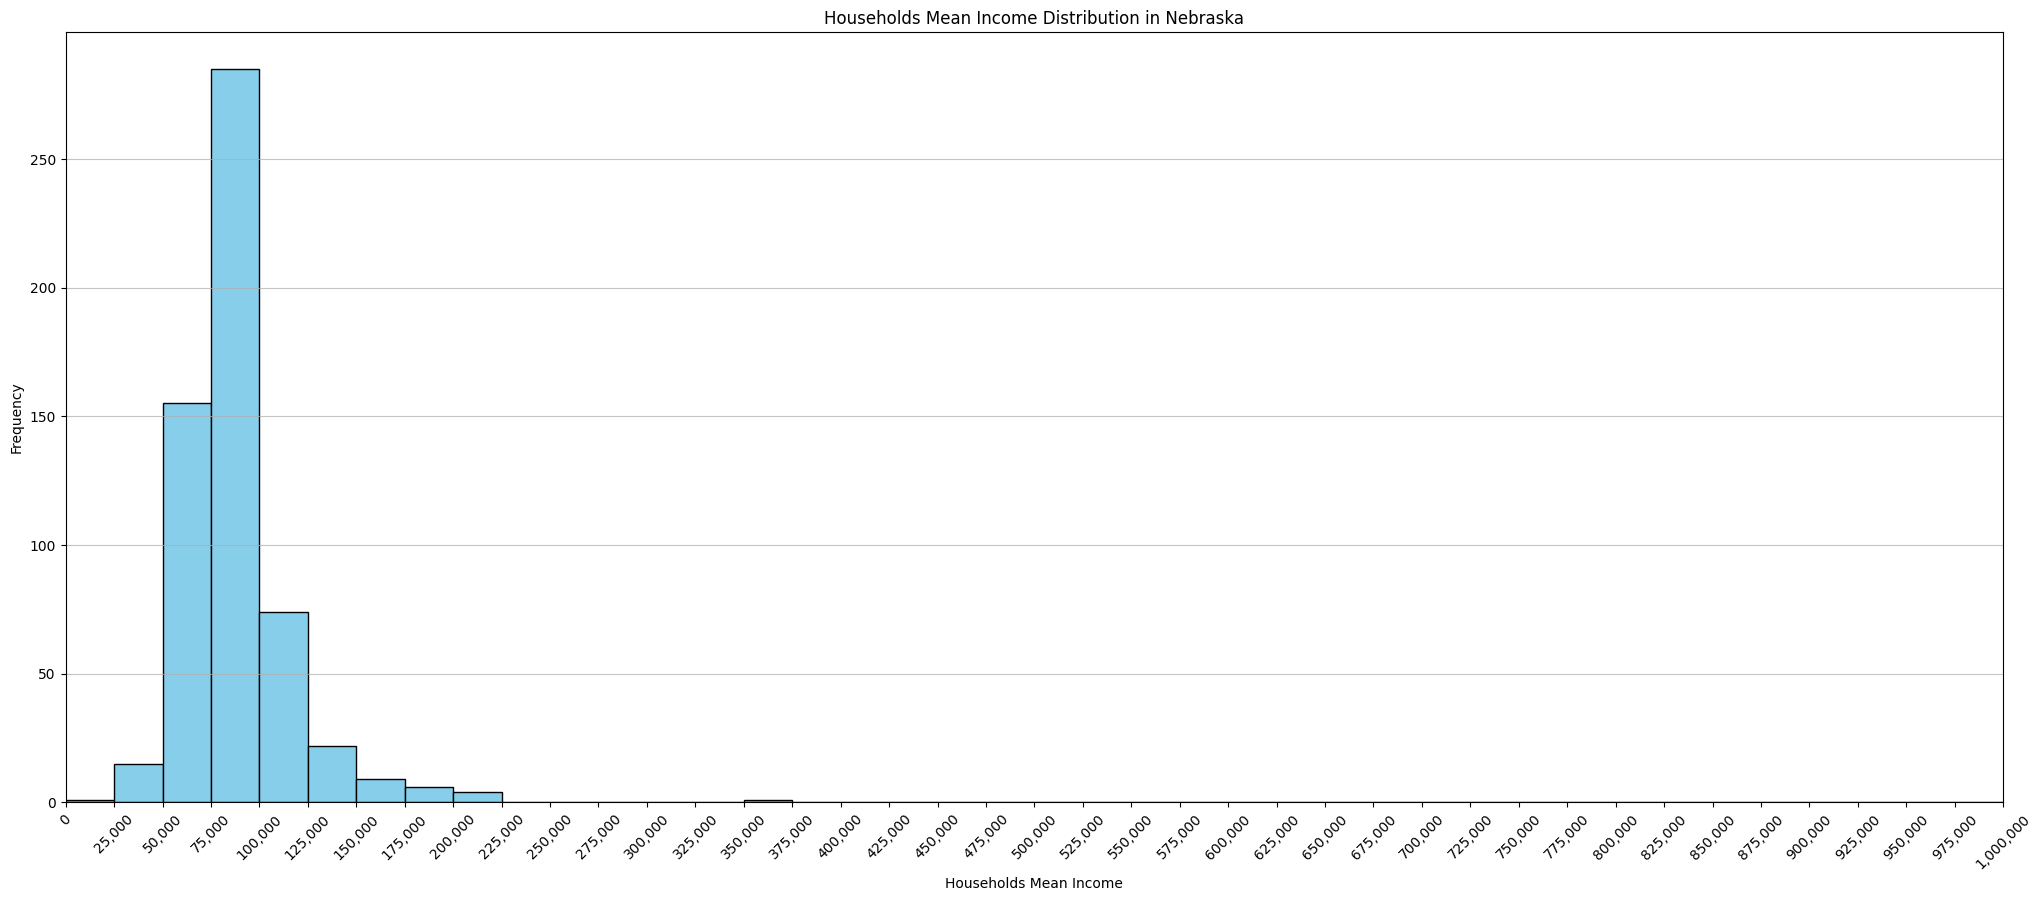

In [ ]:
# Create the dropdown widget
state_dropdown = widgets.Dropdown(
    options=data_merged['Official State Name'].unique(),
    description='State:',
)

# Event handler for when the dropdown value changes
def on_state_selected(change):
    plt.close('all')  # Close the existing plot to prevent overlap
    plot_histogram_for_state_with_bins(change.new)

state_dropdown.observe(on_state_selected, names='value')

# Display the dropdown
display(state_dropdown)

# Scatterplots of Depression


In [ ]:
health_data = health_outcomes[health_outcomes['Category'] == 'Health Outcomes']
health_data = health_data[health_data['Year'] == 2021]
health_data = health_data[['LocationName', 'Measure', 'Data_Value', 'Short_Question_Text']]
health_data.columns = [['Zip Code', 'Measure', 'Value', 'Text']]
health_data.columns = health_data.columns.get_level_values(0)
health_data.head(10)


,Zip Code,Measure,Value,Text
1,01001,Arthritis among adults aged >=18 years,33.7,Arthritis
3,01001,High blood pressure among adults aged >=18 years,33.8,High Blood Pressure
5,01001,Cancer (excluding skin cancer) among adults ag...,9.1,Cancer (except skin)
6,01001,Current asthma among adults aged >=18 years,11.4,Current Asthma
8,01001,Coronary heart disease among adults aged >=18 ...,6.8,Coronary Heart Disease
13,01001,Chronic obstructive pulmonary disease among ad...,7.3,COPD
18,01001,Depression among adults aged >=18 years,24.7,Depression
19,01001,Diagnosed diabetes among adults aged >=18 years,10.1,Diabetes
23,01001,High cholesterol among adults aged >=18 years ...,36.0,High Cholesterol
25,01001,Chronic kidney disease among adults aged >=18 ...,3.3,Chronic Kidney Disease


In [ ]:
# Load Income Data
income_2021 = clean_income_data('/content/drive/MyDrive/Milestone1/income_data_2021.csv')

<ipython-input-262-dc5140cc50a0>:3: DtypeWarning: Columns (2,3,34,35,66,67,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  income_data = pd.read_csv(data, header=None)


In [ ]:
# Fix Multi-Index
income_2021.columns = income_2021.columns.get_level_values(0)
income_2021['Households Mean Income'] = pd.to_numeric(income_2021['Households Mean Income'], errors='coerce')
income_2021.dropna(subset=['Households Mean Income'], inplace=True)

In [ ]:
merged_data = health_data.merge(income_2021, how='inner', on='Zip Code')

depression = merged_data[merged_data['Text'] == 'Depression']
depression

,Zip Code,Measure,Value,Text,Households Mean Income
6,01001,Depression among adults aged >=18 years,24.7,Depression,94323.0
18,01002,Depression among adults aged >=18 years,25.8,Depression,104186.0
30,01005,Depression among adults aged >=18 years,22.8,Depression,106135.0
42,01007,Depression among adults aged >=18 years,23.0,Depression,113474.0
55,82430,Depression among adults aged >=18 years,24.9,Depression,33831.0
...,...,...,...,...,...
365178,99921,Depression among adults aged >=18 years,20.8,Depression,74513.0
365190,99922,Depression among adults aged >=18 years,20.3,Depression,56626.0
365202,99925,Depression among adults aged >=18 years,19.7,Depression,83366.0
365214,99926,Depression among adults aged >=18 years,20.3,Depression,71467.0


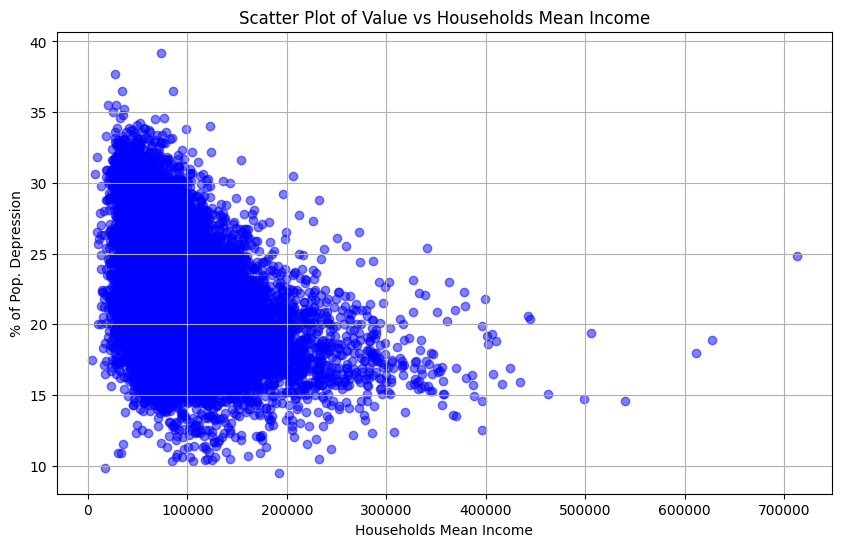

In [408]:
y = depression['Value']
x = depression['Households Mean Income']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, color='b')
plt.title('Scatter Plot of Value vs Households Mean Income')
plt.xlabel('Households Mean Income')
plt.ylabel('% of Pop. Depression')
plt.grid(True)

plt.show()

# Scatterplot of States

In [405]:
# Merge to get State Names
depression['Zip Code'] = depression['Zip Code'].astype(int)
state_zips['Zip Code'] = state_zips['Zip Code'].astype(int)

depression_merged = state_zips.merge(depression, how='inner', on='Zip Code')

<ipython-input-405-618a3c3abf31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  depression['Zip Code'] = depression['Zip Code'].astype(int)


In [401]:
average_depression = depression_merged.groupby('Official State Name').agg({'Value': 'mean', 'Households Mean Income': 'mean'}).reset_index()
average_depression.rename(columns={'Value': "Average Value", 'Households Mean Income': 'Average Households Mean Income'}, inplace=True)
average_depression['Average Value'] = average_depression['Average Value'].round(2)
average_depression["Average Households Mean Income"] = average_depression["Average Households Mean Income"].round()

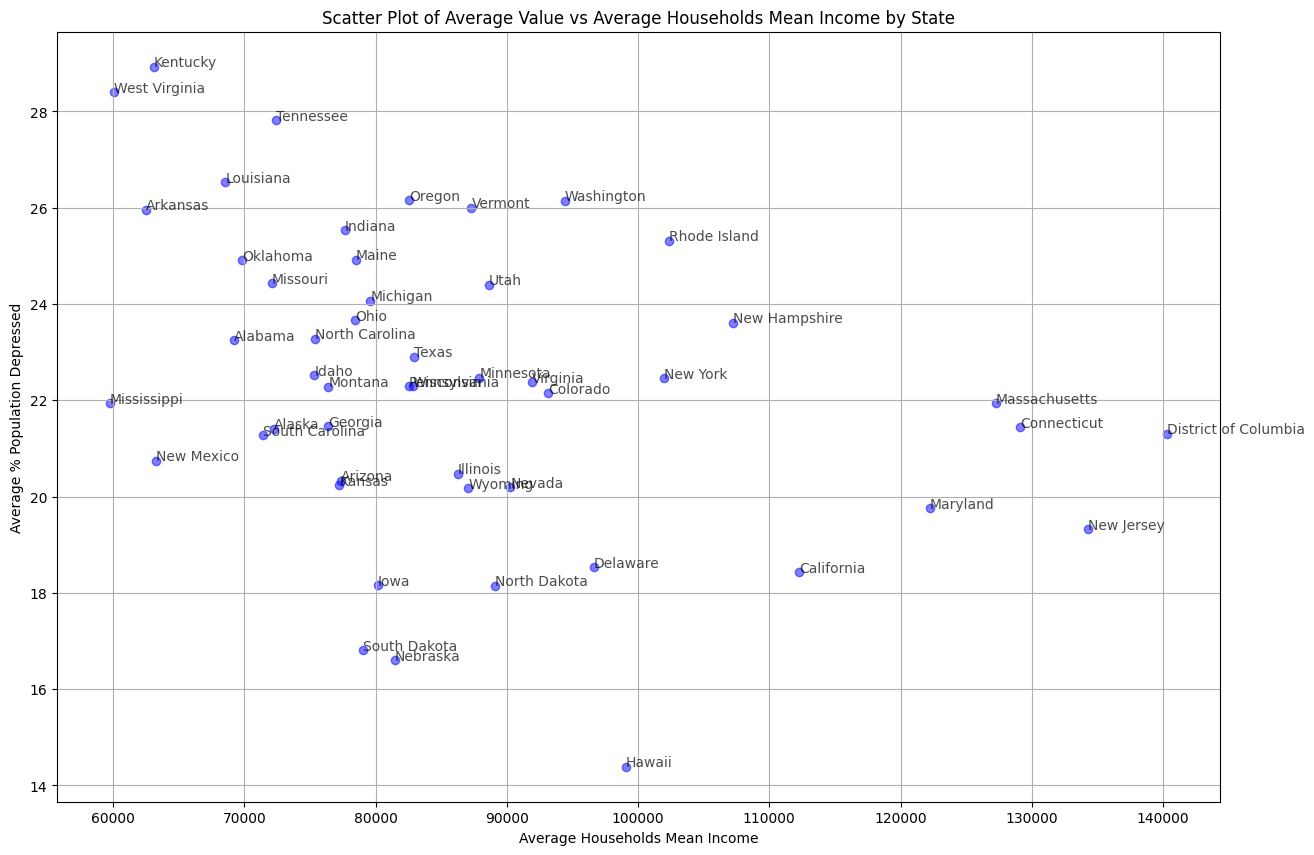

In [409]:
# Make Scatterplot
y = average_depression['Average Value']
x = average_depression['Average Households Mean Income']
state_names = average_depression['Official State Name']

# Create a scatter plot
plt.figure(figsize=(15, 10))
plt.scatter(x, y, alpha=0.5, color='b')

# Annotate dots with state names
for i, state in enumerate(state_names):
    plt.annotate(state, (x[i], y[i]), fontsize=10, alpha=0.7)

plt.title('Scatter Plot of Average Value vs Average Households Mean Income by State')
plt.xlabel('Average Households Mean Income')
plt.ylabel('Average % Population Depressed')
plt.grid(True)

plt.show()